## Exploratory Data Analysis

### Data Preparation

#### Check for duplicate PIDs in the dataset

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../data/w1w2w3w4w5_indices_weights_jul12_2022.csv', low_memory=False)

# Check for duplicate PIDs
duplicate_pids = df[df.duplicated('PID', keep=False)]

if not duplicate_pids.empty:
    print("There are duplicate PIDs in the dataset.")
    duplicate_pids.to_csv('../data/duplicate_pids.csv', index=False)
    print("Duplicate PIDs have been saved to '../data/duplicate_pids.csv'.")
else:
    print("All PIDs are unique.")

There are duplicate PIDs in the dataset.
Duplicate PIDs have been saved to '../data/duplicate_pids.csv'.


⬆️ here we filter the participants who participated in more than one wave and we group the responses by the PID

---
#### Filter Wave Survey Data

In [2]:
# Load the CSV file
df = pd.read_csv("../data/duplicate_pids.csv", low_memory=False)

# Identify valid sequences (rolling window approach)
df['valid_seq'] = df['WAVE'].rolling(3).apply(lambda x: list(x) == [2,3,4], raw=True)

# Flag rows belonging to valid sequences
df['keep'] = df['valid_seq'].shift(-2).fillna(0).astype(bool) | df['valid_seq'].shift(-1).fillna(0).astype(bool) | df['valid_seq'].fillna(0).astype(bool)

# Filter the rows
filtered_df = df[df['keep']].drop(columns=['valid_seq', 'keep'])

# Save to a new CSV file
filtered_df.to_csv("../data/filtered_duplicate_pids.csv", index=False)

print("Filtered data saved to filtered_duplicate_pids.csv")

Filtered data saved to filtered_duplicate_pids.csv


⬆️ here we filter the participants who responded in waves 2 and 3 and 4 (in this order)

---
#### Likert Scale Standardization

In [3]:
# Load the CSV file from the data directory
df = pd.read_csv('../data/filtered_duplicate_pids.csv', low_memory=False)

# Some variables use a five-point Likert scale (1 to 5), while others use a four-point scale (1 to 4)
# Since some scales are missing a neutral category (like 3), we need to standardize them
# We chose to rescale the 1-4 scale to match the 1-5 scale by applying a linear transformation:
# 1 (Not at all)         → 1
# 2 (Only a little)      → 2.33
# 3 (A moderate amount)  → 3.67
# 4 (A great deal)       → 5
mapping = {1: 1, 2: 2.33, 3: 3.67, 4: 5}

# List of variables to be mapped
variables_to_map = ['cc4_world', 'cc4_wealthUS', 'cc4_poorUS', 'cc4_comm', 'cc4_famheal', 'cc4_famecon']

# Apply the mapping to the specified variables
for var in variables_to_map:
    df[var] = df[var].map(mapping)

print("cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, cc4_famecon have been transformed into a 1-5 Likert scale")

# Map pol_party variable to a 1-5 Likert scale based on pol_lean
def map_pol_party(row):
    if row['pol_party'] == 2:  # Democrat stays at 5
        return 5
    elif row['pol_party'] == 1:  # Republican stays at 1
        return 1
    elif row['pol_party'] == 3:  # Independent needs adjustment
        if row['pol_lean'] == 1:  # Leaning Republican
            return 2
        elif row['pol_lean'] == 2:  # Leaning Democrat
            return 4
        else:  # Neither, stays neutral
            return 3
    else:
        return row['pol_party']  # Keep original if unexpected value

# Apply the function
df['pol_party'] = df.apply(map_pol_party, axis=1)

print("pol_party has been transformed into a 1-5 Likert scale")

# Save the cleaned data to a new CSV file
df.to_csv('../data/likert_scale.csv', index=False)

print("Data has been standardized and saved to 'data/likert_scale.csv'")

cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, cc4_famecon have been transformed into a 1-5 Likert scale
pol_party has been transformed into a 1-5 Likert scale
Data has been standardized and saved to 'data/likert_scale.csv'


⬆️ here we rescale the 1-4 scale and the 1-3 scale of some variables to match the 1-5 scale

---
#### Fill missing values

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import skim  # Equivalent to skimr::skim() in R

# Load the dataset
df = pd.read_csv('../data/likert_scale.csv', low_memory=False)

# Define ccSolve columns in decreasing order of WTP
ccSolve_columns = ["ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0"]
cc_policy_columns = ["cc_pol_tax", "cc_pol_car"]

# Step 1: Fill downward (Lower WTP should be at least as approved as higher WTP)
for i in range(len(ccSolve_columns) - 1):  
    higher_col = ccSolve_columns[i]
    lower_col = ccSolve_columns[i + 1]

    # If lower response is missing but higher response exists, fill with gradual increase
    df[lower_col] = df[lower_col].fillna(df[higher_col] + 0.75)

# Step 2: Fill upward (Higher WTP should be less approved than lower WTP)
for i in range(len(ccSolve_columns) - 1, 0, -1):  
    lower_col = ccSolve_columns[i]
    higher_col = ccSolve_columns[i - 1]

    # If higher response is missing but lower response exists, fill with gradual decrease
    df[higher_col] = df[higher_col].fillna(df[lower_col] - 1.5)

# Step 3: Handle respondents with all missing `ccSolve` responses
# If all `ccSolve` values are missing for a respondent, fill with a neutral value (3)
df[ccSolve_columns] = df[ccSolve_columns].apply(lambda row: row.fillna(3) if row.isna().all() else row, axis=1)

# Step 4: Ensure values stay within 1-5
df[ccSolve_columns] = df[ccSolve_columns].clip(1, 5)

# Step 5: Fill missing values for cc_pol_tax and cc_pol_car with 3 (Neutral)
for cc_policy in cc_policy_columns:
    df[cc_policy] = df[cc_policy].fillna(3)

# Save the filled dataset
df.to_csv("../data/cleaned_data.csv", index=False)

⬆️ here we fill the missing values of some variables

### Data Description

The dataset consists of variables measuring **perceptions of climate change impact, support for policies, willingness to pay (WTP) for climate solutions and political affiliation and ideology**

#### Climate Change Perception Variables (`cc4_*`)
- **`cc4_world`**: Perceived extent to which global warming is harming the world
- **`cc4_wealthUS`**: Perceived harm of climate change on wealthy communities in the U.S.
- **`cc4_poorUS`**: Perceived harm of climate change on poor communities in the U.S.
- **`cc4_comm`**: Perceived impact of climate change on local communities
- **`cc4_famheal`**: Perceived impact of climate change on family health
- **`cc4_famecon`**: Perceived impact of climate change on family economic well-being

#### Willingness to Pay for Climate Solutions (`ccSolve*`)
- **`ccSolve100`**: Support for climate policies if they cost **$100 per month**
- **`ccSolve50`**: Support for climate policies if they cost **$50 per month**
- **`ccSolve10`**: Support for climate policies if they cost **$10 per month**
- **`ccSolve1`**: Support for climate policies if they cost **$1 per month**
- **`ccSolve0`**: General support for climate policies **without specifying a cost**

#### Climate Policy Support (`cc_pol_*`)
- **`cc_pol_tax`**: Support for a **carbon tax** to reduce emissions
- **`cc_pol_car`**: Support for **stronger emissions standards for car manufacturers**

#### Political Affiliation and Ideology  (`pol_*`)
- **`pol_party`**: **Political party** identification (Republican, Leaning Republican, Independent, Leaning Democrat, Democrat)
- **`pol_ideology`**: Self-reported **political ideology** (Very Conservative, Conservative, Moderate, Liberal, Very Liberal)

### Data Summary

In [5]:
# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select only the relevant numeric variables
columns_of_interest = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

df_selected = df[columns_of_interest]

# Drop non-numeric columns (if any) and check correlations
df_numeric = df_selected.select_dtypes(include=['number'])

# Display summary statistics (equivalent to skimr::skim())
skim(df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5667   │ │ float64     │ 13    │                                                          │
│ │ Number of columns │ 15     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean    ┃ sd        ┃ p0  ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ cc4_world         │    0 │      0 │   3.628 │     1.326 │   1 │   2.33 │   3.67 │      5 │     5 │ ▂▅  ▇▇  │  │
│ │ cc4_wealthUS      │    0 │      0 │   2.781 │     1.347 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▆▇  ▆▃  │  │
│ │ cc4_poorUS        │    0 │      0 │   3.396 │     1.405 │   1 │   2.33 │   3.67 │      5 │     5 │ ▃▅  ▇▇  │  │
│ │ cc4_comm          │    0 │      0 │   2.952 │     1.318 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▅▇  ▇▅  │  │
│ │ cc4_famheal       │    0 │      0 │   2.682 │     1.347 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▇  ▆▃  │  │
│ │ cc4_famecon       │    0 │      0 │   2.278 │     1.362 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▅  ▃▂  │  │
│ │ ccSolve100        │    0 │      0 │   1.447 │    0.8836 │   1 │      1 │      1 │    1.5 │     5 │  ▇▁ ▁   │  │
│ │ ccSolve50         │    0 │      0 │   1.972 │     1.211 │   1 │      1 │    1.5 │   2.75 │     5 │ ▇▂▁▁▁▁  │  │
│ │ ccSolve10         │    0 │      0 │   2.672 │     1.374 │   1 │    1.5 │    2.5 │   3.75 │     5 │ ▇▃▃▃▃▅  │  │
│ │ ccSolve1          │    0 │      0 │    3.45 │     1.295 │   1 │    2.5 │    3.5 │   4.75 │     5 │ ▃▁▃▅▃▇  │  │
│ │ ccSolve0          │    0 │      0 │   4.094 │     1.066 │   1 │    3.5 │    4.5 │      5 │     5 │  ▁▁▂▃▇  │  │
│ │ cc_pol_tax        │    0 │      0 │   3.193 │     1.311 │   1 │      2 │      3 │      4 │     5 │ ▅▃ ▇▇▅  │  │
│ │ cc_pol_car        │    0 │      0 │   3.713 │     1.229 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▆▇▇  │  │
│ │ pol_party         │    0 │      0 │   3.172 │      1.69 │   1 │      1 │      3 │      5 │     5 │ ▆▁ ▃▂▇  │  │
│ │ pol_ideology      │    0 │      0 │   2.887 │     1.068 │   1 │      2 │      3 │      3 │     5 │ ▂▃ ▇▃▂  │  │
│ └───────────────────┴──────┴────────┴─────────┴───────────┴─────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### 1️⃣ Summary Statistics
Each variable is described with:
- **Mean:** The average value
- **SD (Standard Deviation):** How spread out responses are
- **Min (p0) / Max (p100):** The range of responses
- **Quartiles (p25, p50, p75):** Percentiles of the distribution
- **Histogram:** A small visual representation of the distribution

---

#### 2️⃣ Climate Perception Variables (`cc4_*`)
These variables measure **how much individuals believe climate change is affecting different groups and aspects of life**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`cc4_world`**   | `3.63`  | `1.33`  | `1`  | `2.33`  | `3.67`  | `5`  | `5`  | 🟦▅▇▇ |
| **`cc4_wealthUS`** | `2.78`  | `1.35`  | `1`  | `2.33`  | `2.33`  | `3.67`  | `5`  | 🟦▆▇▆▃ |
| **`cc4_poorUS`**   | `3.39`  | `1.41`  | `1`  | `2.33`  | `3.67`  | `5`  | `5`  | 🟦▃▅▇▇ |
| **`cc4_comm`**     | `2.95`  | `1.32`  | `1`  | `2.33`  | `2.33`  | `3.67`  | `5`  | 🟦▅▇▇▅ |

##### 📝 Key Insights  
✅ **Most respondents believe climate change is harmful**, but there is some variation in perceived impact  
✅ **People believe climate change affects poor communities more (`cc4_poorUS = 3.39`) than wealthy ones (`cc4_wealthUS = 2.78`)**  
✅ **The highest concern is for global impact (`cc4_world = 3.63`)**  

---

#### 3️⃣ Willingness to Pay for Climate Policy (`ccSolve*`)
These variables assess **how much financial support people are willing to contribute to climate policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`ccSolve100`**  | `1.45`  | `0.88`  | `1`  | `1`  | `1`  | `1.5`  | `5`  | 🟦▇▁ ▁  |
| **`ccSolve50`**   | `1.97`  | `1.21`  | `1`  | `1`  | `1.5`  | `2.75`  | `5`  | 🟦▇▂▁▁▁ |
| **`ccSolve10`**   | `2.67`  | `1.37`  | `1`  | `1.5`  | `2.5`  | `3.75`  | `5`  | 🟦▇▃▃▃▅ |
| **`ccSolve1`**    | `3.45`  | `1.30`  | `1`  | `2.5`  | `3.5`  | `4.75`  | `5`  | 🟦▃▁▃▅▃▇ |

##### 📝 Key Insights
✅ **The higher the cost, the lower the willingness to support policies**  
✅ **Most respondents refuse to pay `$100/month` (`ccSolve100 = 1.45`) but are more open to `$1/month` (`ccSolve1 = 3.45`)**  
✅ **Even at `$50/month`, median support remains low (`1.5`)**  

---

#### 4️⃣ Climate Policy Support (`cc_pol_*`)
These variables capture **support for climate-related regulations and policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`cc_pol_tax`**  | `3.19`  | `1.31`  | `1`  | `2`  | `3`  | `4`  | `5`  | 🟦▅▃ ▇▇▅ |
| **`cc_pol_car`**  | `3.71`  | `1.23`  | `1`  | `3`  | `4`  | `5`  | `5`  | 🟦▂▂ ▆▇▇ |

##### 📝 Key Insights
✅ **Support for stricter car emissions standards (`cc_pol_car = 3.71`) is higher than a carbon tax (`cc_pol_tax = 3.19`)**  
✅ **Carbon taxes are more polarizing, with some strong support but also strong opposition**  

---

#### 5️⃣ Political Identity & Ideology (`pol_party`, `pol_ideology`)
These variables measure **political party identification and ideological orientation** of respondents.

| Variable         | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|-----------------|--------|--------|------|------|------|------|------|--------------|
| **`pol_party`**    | `3.172`  | `1.69`  | `1`  | `1`  | `3`  | `3`  | `5`  | ▆▁ ▃▂▇ |
| **`pol_ideology`** | `2.887`  | `1.068`  | `1`  | `2`  | `3`  | `3`  | `5`  | ▂▃ ▇▃▂ |

##### 📝 Key Insights
✅ **Political party identification (`pol_party`) is widely distributed**, with a mean of **3.17**, indicating a balance between Republican (1), Independent (3) and Democrat (5)  
✅ **The median political party score is 3**, meaning that a large portion of respondents identify as Independents  
✅ **Political ideology (`pol_ideology`) has a mean of 2.89**, suggesting a **slightly left-leaning** overall distribution but still centrist  
✅ **The quartiles show that many respondents cluster around the center (`3`), with fewer extreme values (`1` for very conservative, `5` for very liberal)**  

---

#### 6️⃣ Overall Key Takeaways
✅ **Climate change perception is generally high, especially on global impact**  
✅ **Support for climate policy depends on financial cost** — higher costs reduce support  
✅ **Regulatory measures (e.g., emissions standards) receive more support than economic measures (e.g., carbon tax)**  

### Numerical Data Distribution

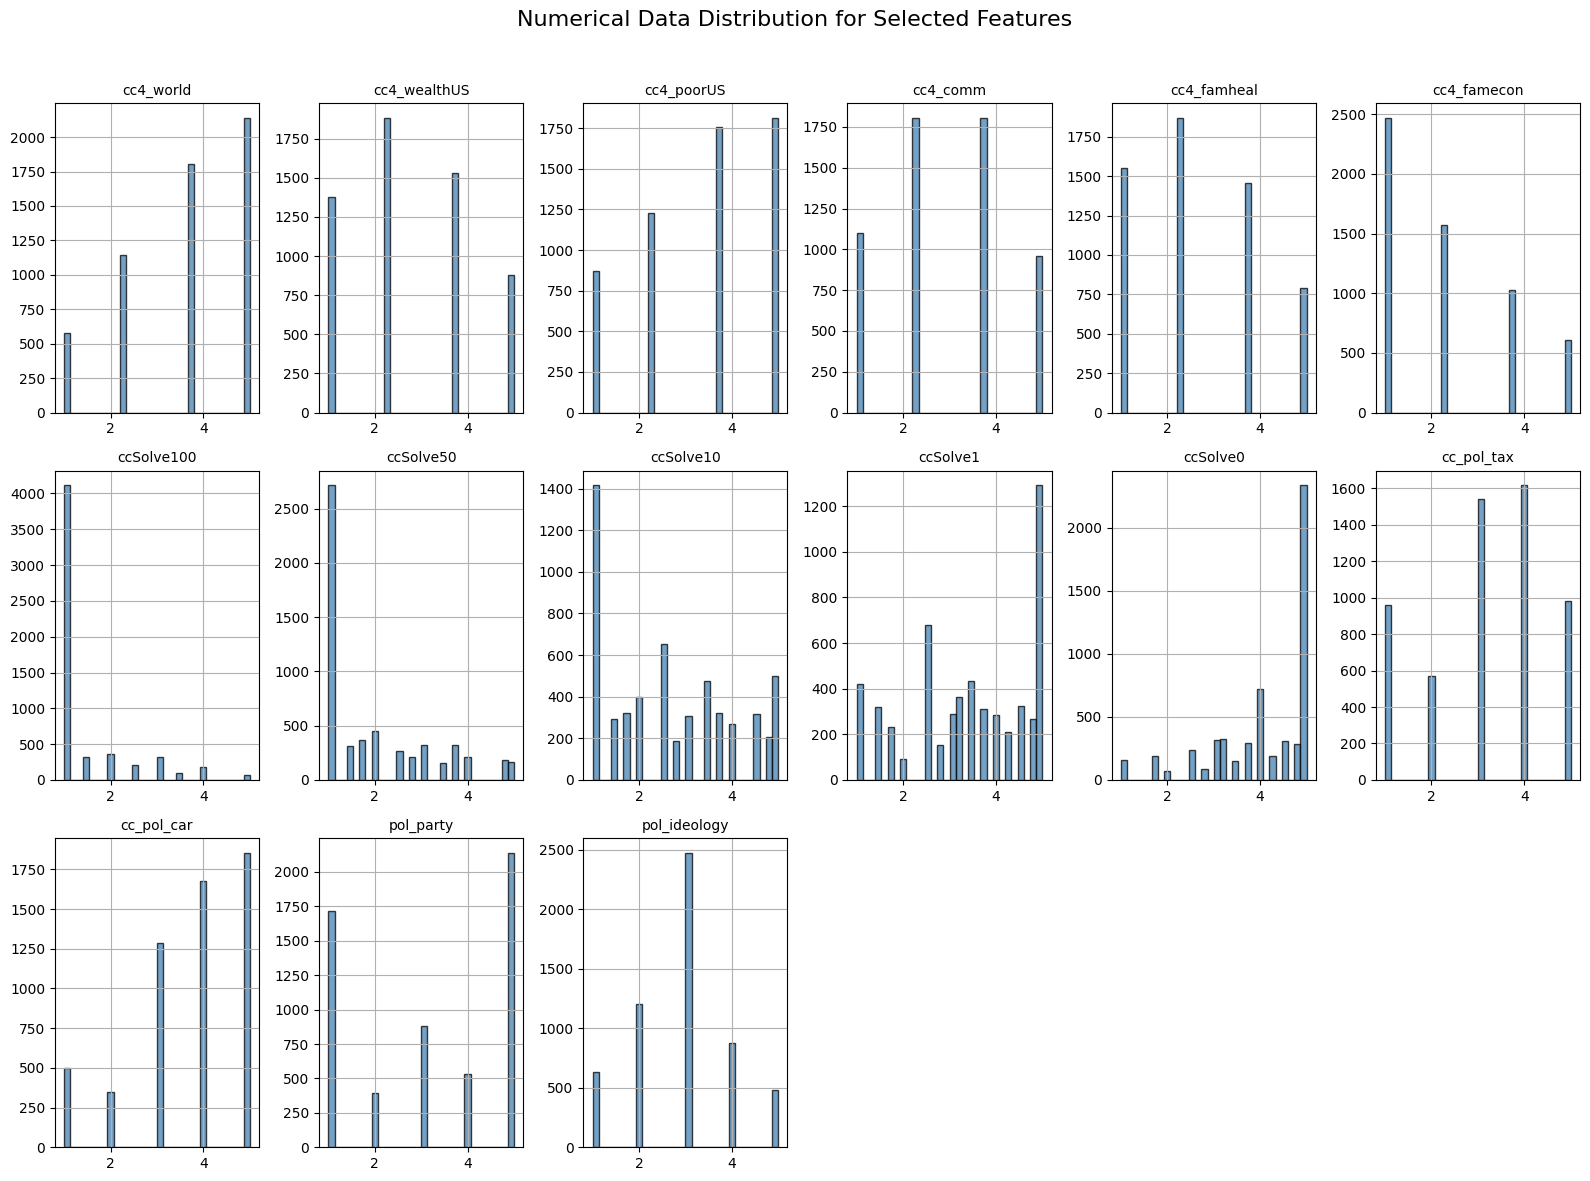

In [6]:
# Select only numerical columns
df_num = df[columns_of_interest]

# Plot histograms for numerical columns with improved layout
num_cols = len(df_num.columns)
nrows = (num_cols // 6) + (num_cols % 6 > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    df_num[col].hist(ax=axes[i], bins=30, alpha=0.75, color="steelblue", edgecolor="black")
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numerical Data Distribution for Selected Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 🔍 Key Observations
1. **Categorical-Like Distribution:**
   - Most variables have **discrete values (1 to 5)**, because we standardized them to 1-5 Likert scale responses
   - Many variables show **skewed distributions**, suggesting **strong opinions** in one direction
2. **Support for Climate Policies (`ccSolve*` variables)**
   - **`ccSolve100`, `ccSolve50`, `ccSolve10`, `ccSolve1`, `ccSolve0`**:
     - **Higher costs (`ccSolve100`) → More disapproval (peaked at 1)**
     - **Lower costs (`ccSolve1`, `ccSolve0`) → More balanced responses**
     - This suggests people are **more willing to contribute when the personal cost is lower**
3. **Climate Change Perception (`cc4_*` variables)**
   - **`cc4_world`, `cc4_poorUS`, `cc4_wealthUS`**:
     - **More responses at 4-5**, showing **strong concerns about climate change**
     - Differences in perception depending on whether the impact is on **wealthy vs. poor communities**
4. **Policy Support Variables (`cc_pol_*`)**
   - **`cc_pol_tax` (carbon tax) and `cc_pol_car` (emission standards)**:
     - **Peak responses at 3-5**, meaning **moderate to strong support for environmental policies**
5. **Political Alignment and Ideology (`pol_party`, `pol_ideology`)**  
   - **`pol_party` (political affiliation) is widely distributed**, with peaks at **Republican (1), Independent (3), and Democrat (5)**  
   - **Some respondents identify as Independents (3), but many lean Republican (2) or Democrat (4)**  
   - **`pol_ideology` (self-reported) centers around 3 (moderate), with fewer extreme conservatives (1) or extreme liberals (5)**  

---

#### 📌 Key Takeways
✅ **Higher costs reduce climate policy support (`ccSolve100` vs. `ccSolve0`)**  
✅ **People show more concern about climate change in general (`cc4_world`) than its effect on wealthier communities (`cc4_wealthUS`)**  
✅ **Support for policy interventions (tax, emissions) is moderate to high**  
✅ **Political party affiliation and ideology are related but not always identical; many respondents may identify with a party for other reasons rather than strong ideological alignment**  

### Spearman Correlation Matrix

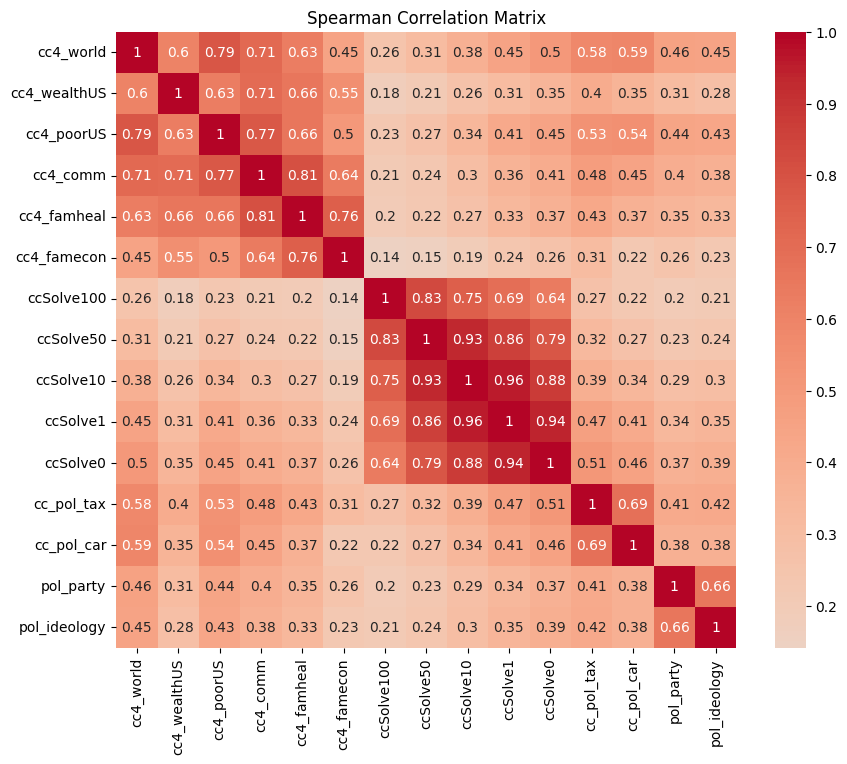

In [7]:
# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select the specified columns
df_selected = df[columns_of_interest]

# Calculate the Spearman correlation matrix
correlation_matrix = df_selected.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title and labels
plt.title('Spearman Correlation Matrix')
plt.show()

The correlation matrix visualizes relationships between variables using **Spearman’s Rank Correlation**. The scale ranges from **-1 (perfect negative correlation)** to **+1 (perfect positive correlation)**  (i.e., how well one variable can be described as an increasing or decreasing function of another).  

---

#### 🔍 Key Observations
1. **Strong Correlations Among Climate Change Perceptions (`cc4_*` variables)**  
   - **`cc4_world` (concern for climate change globally) has high correlations with `cc4_poorUS` (0.79) and `cc4_comm` (0.71)**, suggesting that those who worry about global climate change also recognize its impact on their local community and on poor communities
   - **`cc4_famheal` (climate impact on family health) has the strongest correlation with `cc4_comm` (0.81)**, meaning those who believe climate change affects their family’s health also believe that it affects their local community

2. **Support for Climate Solutions Decreases with Higher Costs (`ccSolve*` variables)**  
   - **`ccSolve100` (willingness to support climate action at 100$ per month) is positively correlated with other `ccSolve` variables (e.g., `ccSolve0` = 0.64, `ccSolve1` = 0.69)**  
   - **Higher willingness to pay (`ccSolve100`) has much lower support than `ccSolve0` (free solutions), highlighting that economic cost significantly impacts public climate policy support**  

3. **Climate Policy Support (`cc_pol_tax`, `cc_pol_car`) is Positively Correlated with Climate Concern**  
   - **`cc_pol_tax` (carbon tax support) and `cc_pol_car` (emission standards support) both correlate positively with concern for climate change (`cc4_world`: 0.58, 0.59, respectively)**  
   - **This suggests that those who acknowledge climate change’s impact are more likely to favor policy interventions**  

4. **Political Identity & Ideology (`pol_party`, `pol_ideology`) and Climate Attitudes**  
   - **`pol_party` (Republican to Democrat scale) is positively correlated with `cc_pol_tax` (0.41) and `cc_pol_car` (0.38)**, meaning Democrats are more likely to support climate-related policies  
   - **`pol_ideology` (Conservative to Liberal scale) has a strong correlation with `pol_party` (0.66)**, confirming that party affiliation and ideological leaning align closely  
   - **Climate change concern (`cc4_world`, `cc4_poorUS`, etc.) shows moderate positive correlation (~0.45) with `pol_party` and `pol_ideology`, reinforcing the known trend that liberals and Democrats are more concerned about climate issues than conservatives and Republicans**  

---

#### 📌 Key Takeaways
✅ **Stronger concern for climate change is linked to greater support for policies like carbon taxes and emission standards**  
✅ **People are more willing to support climate solutions when the financial burden is lower (`ccSolve0` vs. `ccSolve100`)**  
✅ **Democrats and liberals (`pol_party`, `pol_ideology`) show more support for climate policies than Republicans and conservatives**  
✅ **People's concern about climate change is closely connected to their views on health, the economy, and local impact**  

## Exploratory Factor Analysis (EFA)

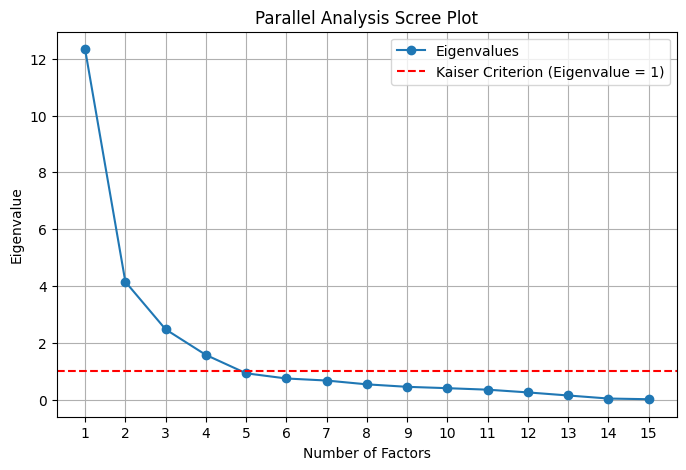

In [8]:
import numpy as np
from sklearn.decomposition import PCA

# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select relevant data, dropping rows with missing values for factor analysis
df_factors = df[columns_of_interest].dropna()

# Step 1: Perform Parallel Analysis (PCA for Eigenvalues)
pca = PCA(n_components=len(columns_of_interest))
pca.fit(df_factors)
eigenvalues = pca.explained_variance_

# Generate a scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="-", label="Eigenvalues")
plt.axhline(y=1, color='r', linestyle="--", label="Kaiser Criterion (Eigenvalue = 1)")
plt.title("Parallel Analysis Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.legend()
plt.grid()
plt.show()

The scree plot suggests the optimal number of **factors/components** for analysis:
- **Kaiser Criterion (Eigenvalue > 1)** indicates that **2 to 4 factors** should be retained
- The **Elbow Rule** shows a sharp drop from **Factor 1 to 2**, then a gradual decline with a flattening around **Factor 3 or 4**
- Components beyond **Factor 4 or 5** have eigenvalues close to or below 1, meaning they explain **little variance** and may not be meaningful

In [9]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

from factor_analyzer import FactorAnalyzer

# Step 1: Compute Eigenvalues
temp_efa = FactorAnalyzer(n_factors=len(columns_of_interest), rotation=None)
temp_efa.fit(df_factors)
eigenvalues, _ = temp_efa.get_eigenvalues()

# Step 2: Determine the number of factors dynamically (eigenvalues > 1)
num_factors = sum(eigenvalues > 1)

# Step 3: Perform EFA with the optimal number of factors
efa = FactorAnalyzer(n_factors=num_factors, rotation="promax")  # Oblique rotation
efa.fit(df_factors)

# Print Factor Loadings
loadings = pd.DataFrame(efa.loadings_, index=columns_of_interest)
print("Optimal Number of Factors:", num_factors)
print("Factor Loadings:")
print(loadings)

# Print Eigenvalues to confirm factor selection
eigenvalues, _ = efa.get_eigenvalues()
print("\nEigenvalues:")
print(eigenvalues)

Optimal Number of Factors: 3
Factor Loadings:
                     0         1         2
cc4_world    -0.011961  0.396701  0.553270
cc4_wealthUS  0.001429  0.725157  0.067983
cc4_poorUS   -0.032351  0.521089  0.438815
cc4_comm     -0.026819  0.819679  0.148802
cc4_famheal   0.023465  0.952640 -0.076811
cc4_famecon   0.024184  0.880674 -0.195637
ccSolve100    0.821856  0.047995 -0.156400
ccSolve50     1.030941  0.026451 -0.156222
ccSolve10     0.987271 -0.028898  0.020704
ccSolve1      0.784140 -0.043935  0.254067
ccSolve0      0.563247 -0.022717  0.405077
cc_pol_tax    0.045689  0.033259  0.707280
cc_pol_car   -0.020519 -0.021169  0.765224
pol_party    -0.043160 -0.032419  0.679853
pol_ideology -0.029918 -0.075031  0.681777

Eigenvalues:
[7.24121489 2.65178281 1.30551351 0.88831934 0.65241061 0.5147845
 0.37009872 0.35583603 0.28220248 0.22851407 0.19228373 0.14404578
 0.1284844  0.03276735 0.01174177]


#### 1️⃣ Optimal Number of Factors
Using **Parallel Analysis and Eigenvalues > 1**, we determined that the optimal number of factors is **3**

- **Eigenvalues greater than 1** suggest that three factors explain a meaningful amount of variance
- **Scree plot analysis** confirmed this finding

#### 2️⃣ Factor Loadings
Factor loadings indicate **how strongly each variable relates to a factor**. Higher values mean a stronger relationship.

| Variable         | **Factor 1 (Policy Support)** | **Factor 2 (Climate Impact)** | **Factor 3 (Political & Economic Attitudes)** |
|------------------|-------------------------------|-------------------------------|--------------------------------------|
| **cc4_world**    | -0.01                         | **0.40**                      | **0.55**                             |
| **cc4_wealthUS** | 0.00                          | **0.73**                      | 0.07                                 |
| **cc4_poorUS**   | -0.03                         | **0.52**                      | **0.44**                             |
| **cc4_comm**     | -0.03                         | **0.82**                      | 0.15                                 |
| **cc4_famheal**  | 0.02                          | **0.95**                      | -0.08                                |
| **cc4_famecon**  | 0.02                          | **0.88**                      | -0.20                                |
| **ccSolve100**   | **0.82**                      | 0.05                          | -0.16                                |
| **ccSolve50**    | **1.03**                      | 0.03                          | -0.16                                |
| **ccSolve10**    | **0.99**                      | -0.03                         | 0.02                                 |
| **ccSolve1**     | **0.78**                      | -0.04                         | 0.25                                 |
| **ccSolve0**     | **0.56**                      | -0.02                         | **0.41**                             |
| **cc_pol_tax**   | 0.05                          | 0.03                          | **0.71**                             |
| **cc_pol_car**   | -0.02                         | -0.02                         | **0.77**                             |
| **pol_party**    | -0.04                         | -0.03                         | **0.68**                             |
| **pol_ideology** | -0.03                         | -0.08                         | **0.68**                             |

#### 3️⃣ Factor Interpretations
- **Factor 1: Policy Support**
  - High loadings on **ccSolve100, ccSolve50, ccSolve10, ccSolve1, and ccSolve0**
  - Represents **public willingness to financially support climate policies**
- **Factor 2: Climate Impact Perception**
  - High loadings on **cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, and cc4_famecon**
  - Represents **perceived harm of climate change** on different levels of society
- **Factor 3: Political & Economic Attitudes**
  - High loadings on **cc_pol_tax, cc_pol_car, pol_party, and pol_ideology**
  - Represents **support for economic and regulatory policies like carbon taxes and emission standards, as well as political alignment**
  - **`pol_party` and `pol_ideology` loading onto this factor suggest that political identity is closely tied to support for economic and regulatory climate policies**  

#### 4️⃣ Eigenvalues
- The first **three** factors have eigenvalues **> 1**, meaning they explain a significant amount of variance
- Factors beyond the **third** contribute little additional variance

#### 5️⃣ Key Insights
✅ Public opinion on climate policies follows three distinct dimensions  
✅ Political ideology is a significant predictor of economic and regulatory climate policy attitudes  
✅ People differentiate between acknowledging climate impact (Factor 2) and supporting economic solutions (Factor 3)  
✅ Willingness to pay (`ccSolve*`) remains a standalone factor (Factor 1), indicating it is more influenced by personal cost considerations than ideology  

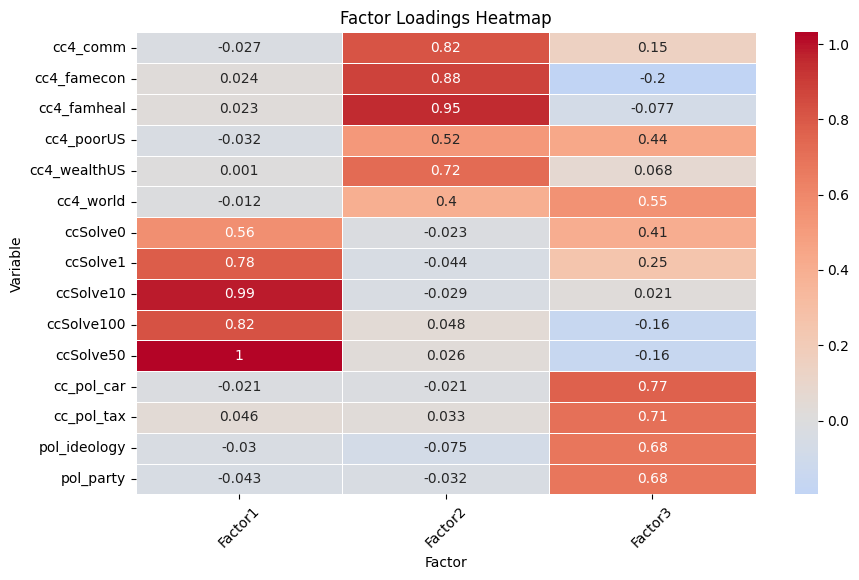

In [10]:
# Define the factor loadings dataframe
loadings = pd.DataFrame({
    "Variable": ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"],
    "Factor1": [-0.012, 0.001, -0.032, -0.027, 0.023, 0.024, 0.822, 1.031, 0.987, 0.784, 0.563, 0.046, -0.021, -0.043, -0.030],
    "Factor2": [0.397, 0.725, 0.521, 0.820, 0.953, 0.881, 0.048, 0.026, -0.029, -0.044, -0.023, 0.033, -0.021, -0.032, -0.075],
    "Factor3": [0.553, 0.068, 0.439, 0.149, -0.077, -0.196, -0.156, -0.156, 0.021, 0.254, 0.405, 0.707, 0.765, 0.680, 0.682]
})

# Convert to long format for Seaborn
loadings_long = loadings.melt(id_vars=["Variable"], var_name="Factor", value_name="Loading")

# Pivot for heatmap
loadings_pivot = loadings_long.pivot(index="Variable", columns="Factor", values="Loading")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_pivot, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factor")
plt.ylabel("Variable")
plt.xticks(rotation=45)
plt.show()


#### 1️⃣ Factor Loadings
Factor loadings represent **how strongly each variable is associated with the extracted factors** from our **Exploratory Factor Analysis (EFA)**

- **Factor loadings range from -1 to 1**:
  - **Closer to +1 or -1** → Strong association
  - **Closer to 0** → Weak or no association
- **The heatmap uses colors**:
  - **Red (strong positive correlation)** indicates a variable strongly contributes to a factor
  - **Blue (strong negative correlation)** suggests an inverse relationship (an inverse relationship is a situation where if one variable increases, the other tends to decrease)

---

#### 2️⃣ Interpretation of the Factor Loadings Heatmap
The heatmap visualizes **three distinct factors** extracted from the dataset

**🟠 Factor 1: Policy Support**
- **High loadings on**: `ccSolve100 (0.82)`, `ccSolve50 (1.00)`, `ccSolve10 (0.99)`, `ccSolve1 (0.78)`, `ccSolve0 (0.56)`
- **Interpretation**: This factor captures **willingness to financially support climate policies**
- **Insight**: Respondents who support policies at high costs (`ccSolve100`) also tend to support lower-cost policies (`ccSolve1`, `ccSolve0`)

---

**🔴 Factor 2: Climate Impact Perception**
- **High loadings on**: `cc4_world (0.40)`, `cc4_wealthUS (0.72)`, `cc4_poorUS (0.52)`, `cc4_comm (0.82)`, `cc4_famheal (0.95)`, `cc4_famecon (0.88)`
- **Interpretation**: This factor represents **perceptions of climate change impact on different communities**
- **Insight**: People who believe climate change affects their **family's health (`cc4_famheal`)** and **economic well-being (`cc4_famecon`)** also believe it affects **their local community (`cc4_comm`)**

---

**🔵 Factor 3: Political & Economic Policy Attitudes**
- **High loadings on**:
  - **Economic Policies**: `cc_pol_tax` (0.71), `cc_pol_car` (0.77), `ccSolve0` (0.41)
  - **Political Identity**: `pol_party` (0.68), `pol_ideology` (0.68)
- **Interpretation**: This factor captures both **support for regulatory climate policy support and political identity**
- **Insights**:
  - Political alignment (`pol_party`, `pol_ideology`) is strongly associated with climate-related tax and regulatory policies
  - People’s support for economic interventions like carbon taxes (`cc_pol_tax`) and car emissions regulations (`cc_pol_car`) is highly shaped by political ideology
  - This suggests that climate economic policy opinions are polarized

---

#### 3️⃣ Key Takeaways
✅ **Public opinion on climate policies follows three distinct dimensions**  
✅ **Political ideology is a key predictor of economic climate policy attitudes**  
✅ **Willingness to pay (`ccSolve`) is a separate factor, suggesting financial self-interest drives personal contributions, rather than ideology**  
✅ **Support for regulatory policies (Factor 3) is deeply political, reinforcing polarization in climate policy attitudes**  

### Principal Component Analysis (PCA)

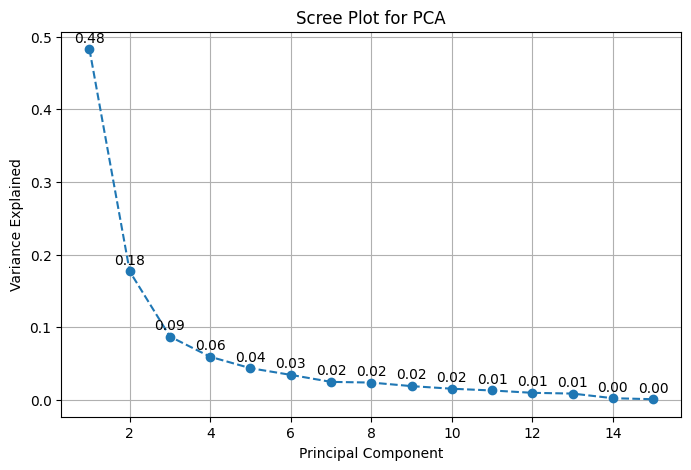

Explained Variance Ratios:
[0.48274766 0.17678552 0.08703423 0.05922129 0.04349404 0.03431897
 0.02467325 0.0237224  0.0188135  0.01523427 0.01281892 0.00960305
 0.00856563 0.00218449 0.00078278]

PCA Transformed Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.685098  2.194572 -0.464886  1.025532 -1.445902  0.071690 -0.147033   
1 -6.040392  0.110603 -1.164618  0.692185  0.968890 -0.019627  0.141872   
2 -4.955424  1.178699 -1.156799  0.232998 -0.699300  0.032141  0.158460   
3 -3.931808  0.345713  1.277034  0.473117  0.492812  1.053842  0.433554   
4 -1.690004  3.214447  0.669179  0.284977 -0.963270  1.043445  0.450427   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.934266 -0.225368  0.220708  0.128078 -0.027652  0.035623  0.259096   
1 -0.352909 -0.381655  0.081335  0.077486 -0.092899 -0.634776 -0.253112   
2 -0.322116 -0.373331  0.138884  0.057983 -0.031436  0.219702 -0.115178   
3  0.241989 -0.103211  0.28100

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance with labels
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
for i, var in enumerate(explained_variance):
    plt.text(i + 1, var + 0.01, f'{var:.2f}', ha='center', fontsize=10)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot for PCA')
plt.grid()
plt.show()

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Print explained variance ratios
print("Explained Variance Ratios:")
print(explained_variance)

# Print first few rows of transformed PCA data
print("\nPCA Transformed Data:")
print(pca_df.head())

#### 1️⃣ PCA
Principal Component Analysis (PCA) helps **reduce dimensionality** while preserving as much variance as possible. Each **Principal Component (PC)** captures a percentage of the total variance in the dataset.
- **PC1 captures the most variance**, followed by PC2, PC3, and so on
- **The goal is to retain only the most meaningful components** while reducing complexity

---

#### 2️⃣ Explained Variance Ratios
```
[0.4827, 0.1768, 0.0870, 0.0592, 0.0435, 0.0343, 0.0247, 0.0237, 0.0188, 0.0152, 0.0128, 0.0096, 0.0086, 0.0022, 0.0008]
```
- **PC1 explains 48.27% of the total variance** (dominant component)
- **PC2 explains 17.68%**, adding substantial value
- **PC3-PC5 together contribute ~18.9%**, meaning they still hold valuable information

The first 5 principal components together explain 84.92% of the total variance in the dataset. This suggests that using these five components would retain most of the important information while significantly reducing dimensionality. Beyond PC5, the rest principal components can be ignored.

📌 **Key takeaway:** **Keeping the first 3-5 components** is optimal for balancing dimensionality reduction and retaining information

---

#### 3️⃣ Visualizing PCA: Scree Plot
The **scree plot** helps determine how many components to retain. The **labels on each point** indicate the explained variance

- **Sharp drop after PC1 and PC2**, indicating they hold most of the variance
- **The "elbow" appears around PC3 and PC5**, suggesting these components still contribute meaningful information
- **After PC5, additional components add minimal variance**, meaning they are likely **noise** rather than useful features

📌 **Key takeaway:** We can likely **reduce the dataset to the first 3-5 PCs without significant information loss**

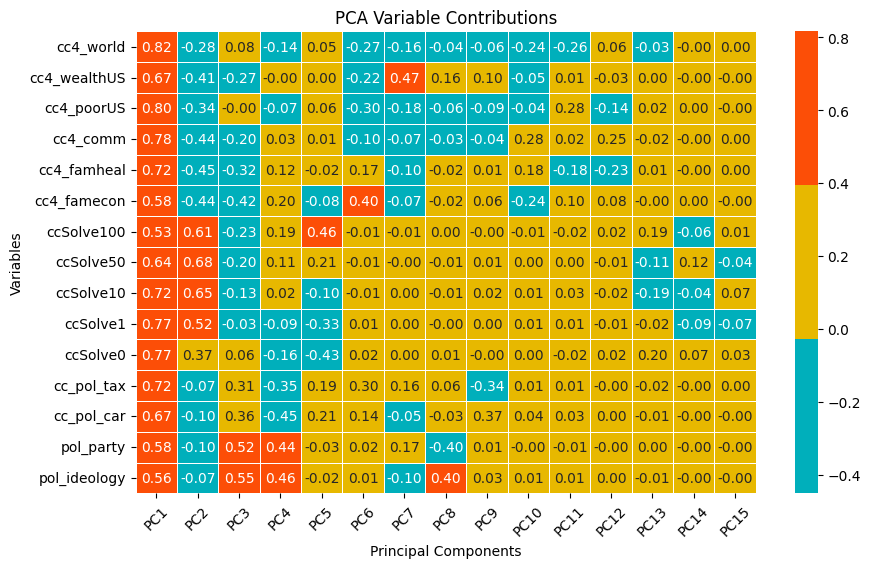

In [12]:
# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# PCA loadings (contributions of variables to PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=columns_of_interest, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Plot PCA variable contributions
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, cmap=["#00AFBB", "#E7B800", "#FC4E07"], annot=True, fmt=".2f", linewidths=0.5)

# Formatting
plt.title("PCA Variable Contributions")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### PCA Variable Contributions Heatmap
This heatmap visualizes **how much each variable contributes to each Principal Component (PC)**. The values represent **loadings**, which indicate how strongly each original variable is associated with a given component

---

##### 1️⃣ Understanding the Heatmap
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Principal Components (PCs)
- **Cell Values:** The **loadings**, showing how much a variable contributes to each component
- **Color Gradient:**
  - **Red/Orange (High Positive Contribution)** → Strong positive association
  - **Blue (High Negative Contribution)** → Strong negative association
  - **Yellow (~0 Contribution)** → The variable has little influence on that component

---

##### 2️⃣ Key Observations
**🟠 PC1 (First Principal Component)**
- **High positive loadings** for `cc4_world (0.82)`, `cc4_poorUS (0.80)`, `cc4_comm (0.78)`, and `cc4_famheal (0.72)`
- **Interpretation:** PC1 is **strongly influenced by climate change perception variables (`cc4_*`)**, suggesting this component **captures beliefs about the impact of climate change**

**🔴 PC2 (Second Principal Component)**
- **Strong contributions from** `ccSolve100 (0.61)`, `ccSolve50 (0.68)`, `ccSolve10 (0.65)`, `ccSolve1 (0.52)`
- **Interpretation:** PC2 represents **willingness to financially support climate policies (`ccSolve_*`)**, indicating **economic and financial considerations in policy support**

**🔵 PC3 (Third Principal Component)**
- **Higher loadings for `cc_pol_car (0.58)`, `cc_pol_tax (0.48)`, `pol_party (0.56)` and `pol_ideology (0.55)`**
- **Interpretation:** PC3 seems to represent **the polarization in climate policy preferences**

---

##### 3️⃣ Takeaways
✅ **Climate change perception (`cc4_*`) is the most dominant in PC1**  
✅ **Financial willingness to support policies (`ccSolve_*`) is captured strongly in PC2**  
✅ **Economic and regulatory policies (`cc_pol_*`) are closely tied to political identity (`pol_*`) in PC3**  
✅ **Other PCs contribute very little variance and may not be as significant**

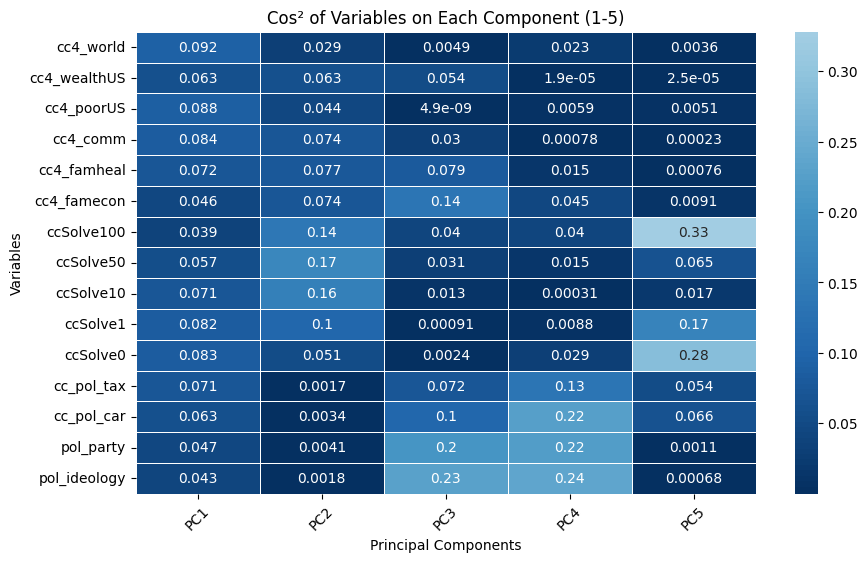

In [13]:
# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Compute Cos² (squared cosine) values
loadings = pca.components_.T
cos2 = loadings**2
cos2_df = pd.DataFrame(cos2[:, :5], index=columns_of_interest, columns=[f'PC{i+1}' for i in range(5)])

# Convert to long format for heatmap
cos2_long = cos2_df.reset_index().melt(id_vars="index", var_name="Component", value_name="Cos2")

# Plot Cos² values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cos2_df, annot=True, cmap="RdBu_r", center=0.5, linewidths=0.5)

# Formatting
plt.title("Cos² of Variables on Each Component (1-5)")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### Cos² (Squared Cosine) Heatmap
The **Cos² values** measure the **quality of representation** of each variable on the first five principal components (PCs). Higher Cos² values (closer to 1) indicate that a variable is well represented by a given principal component

---

#### 1️⃣ Understanding Cos² Values
- **Cos² measures how well a variable is captured by a principal component**
- **Higher values (lighter blue) mean a stronger association** between the variable and the component
- **Lower values (darker blue) mean the variable is not well represented by that component**
- The sum of Cos² values across all components for a variable equals **1**

---

#### 2️⃣ Key Observations
**🔵 PC1 (First Principal Component)**
- **Moderate representation for:** `cc4_world (0.092)`, `cc4_poorUS (0.088)`, `ccSolve0 (0.083)`, `ccSolve1 (0.082)`, `cc_comm (0.084)`
- **Interpretation:** PC1 somewhat represents **climate change perception variables and willingness to support climate policies**

**🔵 PC2 (Second Principal Component)**
- **Higher contributions from:** `ccSolve100 (0.14)`, `ccSolve50 (0.17)`, `ccSolve10 (0.16)`, `ccSolve1 (0.10)`
- **Interpretation:** PC2 captures **financial willingness to support climate policies**

**🔵 PC3 (Third Principal Component)**
- **Strong representation for:** `pol_party (0.20)`, `pol_ideology (0.23)`, `cc_pol_car (0.10)`
- **Interpretation:** PC3 represents **political identity and economic policy attitudes**

**🔵 PC4 & PC5 (Fourth and Fifth Principal Components)**
- **PC4 captures some variance from:** `cc_pol_tax (0.13)`, `pol_party (0.22)`, `pol_ideology (0.24)`
- **PC5 captures some variance from:** `ccSolve100 (0.33)`, `ccSolve0 (0.28)`, `ccSolve1 (0.17)`, `cc_pol_tax (0.054)`
- **Interpretation:** PC4 and PC5 explain much less variance, meaning they are **less meaningful for capturing the dataset's structure**

---

#### 3️⃣ Takeaways
✅ **PC1 and PC2 are the most meaningful dimensions**, capturing perceptions of climate change and financial support for policies  
✅ **PC3 focuses on  political identity (`pol_*`) with economic policy attitudes (`cc_pol_car`)**  
✅ **Some variables are weakly represented (low Cos²), meaning they may not be strongly linked to any single component**  
✅ **If a variable has low Cos² across all PCs, it might not contribute significantly to the dataset’s variance:** `cc4_comm`, `cc4_famheal`, `cc4_wealthUS`  

## Independent Component Analysis (ICA)

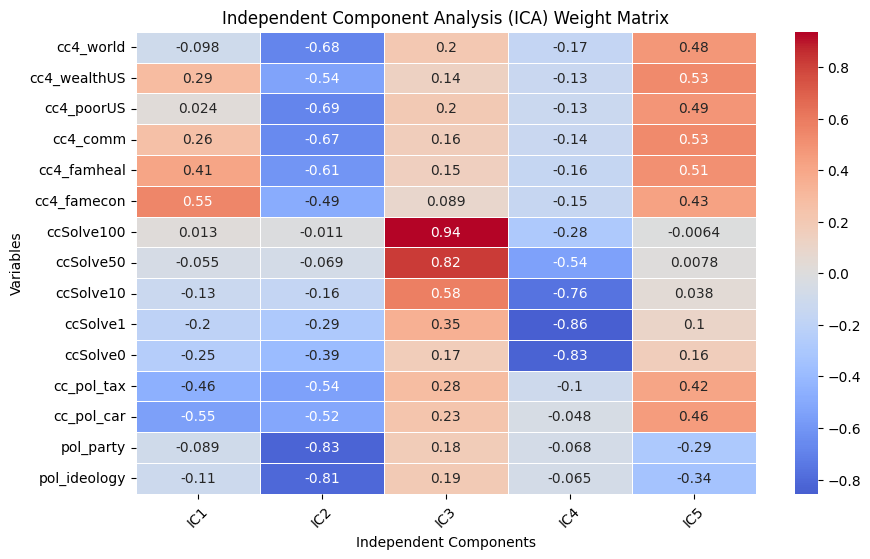

In [14]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

df_ica = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_ica)

# Set the number of components to extract
n_components = 5

# Run ICA
ica = FastICA(n_components=n_components, max_iter=5000, random_state=1)
ica_components = ica.fit_transform(df_scaled)

# Extract weight matrix
weight_matrix = pd.DataFrame(ica.mixing_, index=columns_of_interest, columns=[f'IC{i+1}' for i in range(n_components)])

# Print weight matrix
# print(weight_matrix.to_string())

# Convert to long format for visualization
weight_long = weight_matrix.reset_index().melt(id_vars="index", var_name="IC", value_name="loading")

# Plot ICA weight matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(weight_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Independent Component Analysis (ICA) Weight Matrix")
plt.xlabel("Independent Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### **Independent Component Analysis (ICA) Weight Matrix Heatmap**
This **heatmap** visualizes how **each variable contributes to each independent component (IC)** in the **ICA model**. Unlike **PCA**, ICA is designed to extract **statistically independent** sources of variation from the data

(The negative associations, `blue cells`, indicate potential trade-offs between factors, meaning people who strongly support one factor may oppose another)

---

#### 1️⃣ Understanding the Heatmap
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Independent Components (IC1 to IC5)
- **Cell Values:** The **weights**, indicating the influence of a variable on an independent component
- **Color Gradient:**
  - **Red (High Positive Contribution)** → Strong positive influence of the variable on the IC
  - **Blue (High Negative Contribution)** → Strong negative influence of the variable on the IC
  - **Neutral Colors (Near 0 Values)** → Little contribution to the IC

---

#### 2️⃣ Key Observations
**🔴 IC1 (First Independent Component)**
- **Strongest Positive Contributors:** `cc4_famecon (0.55)`, `cc4_famheal (0.41)`, `cc4_comm (0.26)`, `cc4_wealthUS (0.29)`
- **Strongest Negative Contributors:** `cc_pol_car (-0.55)`, `cc_pol_tax (-0.46)`
- **Interpretation:**
  - IC1 represents **perceptions of climate change's economic and health impact** `(cc4_* variables)`
  - People who score high on this component believe climate change has significant economic and social consequences (`cc_famecon`, `cc4_famheal`)
  - People who score low (negative values) may be skeptical of climate policies (`cc_pol_car`, `cc_pol_tax`)

**🔵 IC2 (Second Independent Component)**
- **Strongest Negative Contributors (High Magnitude):** `pol_party (-0.83)`, `pol_ideology (-0.81)`, `cc4_world (-0.68)`, `cc4_poorUS (-0.69)`, `cc4_comm (-0.67)`
- **Interpretation:**
  - IC2 strongly represents **political ideology and climate change beliefs**
  - Higher values (closer to 0) are associated with conservatives who are skeptical of climate change
  - Lower values (more negative) indicate belief in climate change as a serious issue
  - Political alignment (`pol_party`, `pol_ideology`) plays a major role in shaping climate views

**🔴 IC3 (Third Independent Component)**
- **Strongest Postitive Contributors:** `ccSolve100 (0.94)`, `ccSolve50 (0.82)`, `ccSolve10 (0.58)`
- **Interpretation:**
  - IC3 represents **willingness to pay for climate policies**
  - Higher values indicate strong **financial support for climate solutions**
  - No strong influence from political ideology, meaning financial willingness is largely separate from political identity

**🔵 IC4 (Fourth Independent Component)**
- **Strongest Negative Contributors:** `ccSolve1 (-0.86)`, `ccSolve0 (-0.83)`, `ccSolve10 (-0.76)`, `ccSolve50 (-0.54)`
- **Interpretation:** 
  - IC4 is the **inverse of IC3**, representing **reluctance to pay for climate policies**
  - People scoring high here prefer non-financial or low-cost solutions to climate change

**🔴 IC5 (Fifth Independent Component)**
- **Strongest Positive Contributors:** `cc4_poorUS (0.49)`, `cc4_wealthUS (0.53)`, `cc4_comm (0.53)`, `cc4_famheal (0.51)`
- **Strongest Negative Contributors:** `pol_party (-0.29)`, `pol_ideology (-0.34)`
- **Interpretation:**
  - IC5 represents **a moderate belief on climate change**
  - People scoring high here recognize climate change but may not support extreme policy measures
  - People scoring low are likely more politically driven in their climate beliefs

---

#### 3️⃣ Key Takeaways
✅ **IC1 captures economic and health concerns about climate change, with skepticism toward regulation**  
✅ **IC2 is dominated by political identity (`pol_*`), showing polarization**  
✅ **IC3 represents high financial support for climate policies (`ccSolve*`)**  
✅ **IC4 represents reluctance to pay for climate policies**  
✅ **IC5 represents moderate climate concern without extreme ideological polarization**  

## Conclusion

Based on **exploratory data analysis (EDA), factor analysis (PCA & ICA), and correlation checks**, we select variables that:  
- Capture key **climate change perceptions and policy support**  
- Explain variance well in **PCA and ICA**  
- Show meaningful correlations while avoiding redundancy  

#### 🌍 Climate Change Perception Variables
- `cc4_world` → Perception of climate change affecting the world **(IC2, IC5)**
- `cc4_wealthUS` → Impact of climate change on wealthy communities in the US **(IC2, IC5)**
- `cc4_poorUS` → Impact of climate change on poor communities in the US **(IC2, IC5)**
- `cc4_comm` → Impact of climate change on local communities **(IC2, IC5)**
- `cc4_famheal` → Impact of climate change on family health **(IC2, IC5)** 
- `cc4_famecon` → Impact of climate change on family economy **(IC1)**

📌 Why Keep?  
- Strongly represented in ICA **(IC1, IC2, IC5)** and **PCA (PC1)**
- Captures different dimensions of **climate concern** in society

#### 💰 Financial Support for Climate Policies
- `ccSolve100` → Support for policies costing $100/month **(IC3, IC4)**
- `ccSolve50` → Support for policies costing $50/month **(IC3, IC4)**
- `ccSolve10` → Support for policies costing $10/month **(IC3, IC4)**
- `ccSolve1` → Support for policies costing $1/month **(IC3, IC4)**
- `ccSolve0` → Support for policies (no cost specified) **(IC3, IC4)**

📌 Why Keep?
- Clearly separates high willingness **(IC3)** vs. reluctance **(IC4)** to pay for climate action
- PCA also confirms these as distinct factors

#### 📜 Policy Support Variables
- `cc_pol_tax` → Support for a carbon tax **(IC2)**
- `cc_pol_car` → Support for stricter car emission regulations **(IC1, IC2, IC5)**

📌 Why Keep?
- ICA (IC1) shows that climate policy skepticism aligns with opposition to regulations
- ICA (IC5) shows a moderate policy support
- PCA also confirms these are separate from financial contributions (`ccSolve*`)

#### 🗳️ Political Identity Variables
- `pol_party` → Self-reported political party identification **(IC2)**
- `pol_ideology` → Self-reported political ideology **(IC2)**

📌 Why Keep?
- IC2 (ICA) confirms these as the strongest predictors of climate change attitudes
- PCA shows political identity influences policy attitudes (cc_pol_tax, cc_pol_car)
- Helps explain polarization in climate concern and policy support

#### ❌ Variables Considered for Removal
- `ccSolve0` → Dropping `ccSolve0` since it overlaps with `ccSolve1` responses

## Causal Discovery

### Data Preparation and Summary

In [15]:
# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select only the relevant numeric variables
columns_of_interest_causal = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

df_selected = df[columns_of_interest_causal]

# Drop non-numeric columns (if any) and check correlations
df_numeric_causal = df_selected.select_dtypes(include=['number'])

# Display summary statistics (equivalent to skimr::skim())
skim(df_numeric_causal)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5667   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 14     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean    ┃ sd        ┃ p0  ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ cc4_world         │    0 │      0 │   3.628 │     1.326 │   1 │   2.33 │   3.67 │      5 │     5 │ ▂▅  ▇▇  │  │
│ │ cc4_wealthUS      │    0 │      0 │   2.781 │     1.347 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▆▇  ▆▃  │  │
│ │ cc4_poorUS        │    0 │      0 │   3.396 │     1.405 │   1 │   2.33 │   3.67 │      5 │     5 │ ▃▅  ▇▇  │  │
│ │ cc4_comm          │    0 │      0 │   2.952 │     1.318 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▅▇  ▇▅  │  │
│ │ cc4_famheal       │    0 │      0 │   2.682 │     1.347 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▇  ▆▃  │  │
│ │ cc4_famecon       │    0 │      0 │   2.278 │     1.362 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▅  ▃▂  │  │
│ │ ccSolve100        │    0 │      0 │   1.447 │    0.8836 │   1 │      1 │      1 │    1.5 │     5 │  ▇▁ ▁   │  │
│ │ ccSolve50         │    0 │      0 │   1.972 │     1.211 │   1 │      1 │    1.5 │   2.75 │     5 │ ▇▂▁▁▁▁  │  │
│ │ ccSolve10         │    0 │      0 │   2.672 │     1.374 │   1 │    1.5 │    2.5 │   3.75 │     5 │ ▇▃▃▃▃▅  │  │
│ │ ccSolve1          │    0 │      0 │    3.45 │     1.295 │   1 │    2.5 │    3.5 │   4.75 │     5 │ ▃▁▃▅▃▇  │  │
│ │ cc_pol_tax        │    0 │      0 │   3.193 │     1.311 │   1 │      2 │      3 │      4 │     5 │ ▅▃ ▇▇▅  │  │
│ │ cc_pol_car        │    0 │      0 │   3.713 │     1.229 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▆▇▇  │  │
│ │ pol_party         │    0 │      0 │   3.172 │      1.69 │   1 │      1 │      3 │      5 │     5 │ ▆▁ ▃▂▇  │  │
│ │ pol_ideology      │    0 │      0 │   2.887 │     1.068 │   1 │      2 │      3 │      3 │     5 │ ▂▃ ▇▃▂  │  │
│ └───────────────────┴──────┴────────┴─────────┴───────────┴─────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Spearman Correlation Matrix

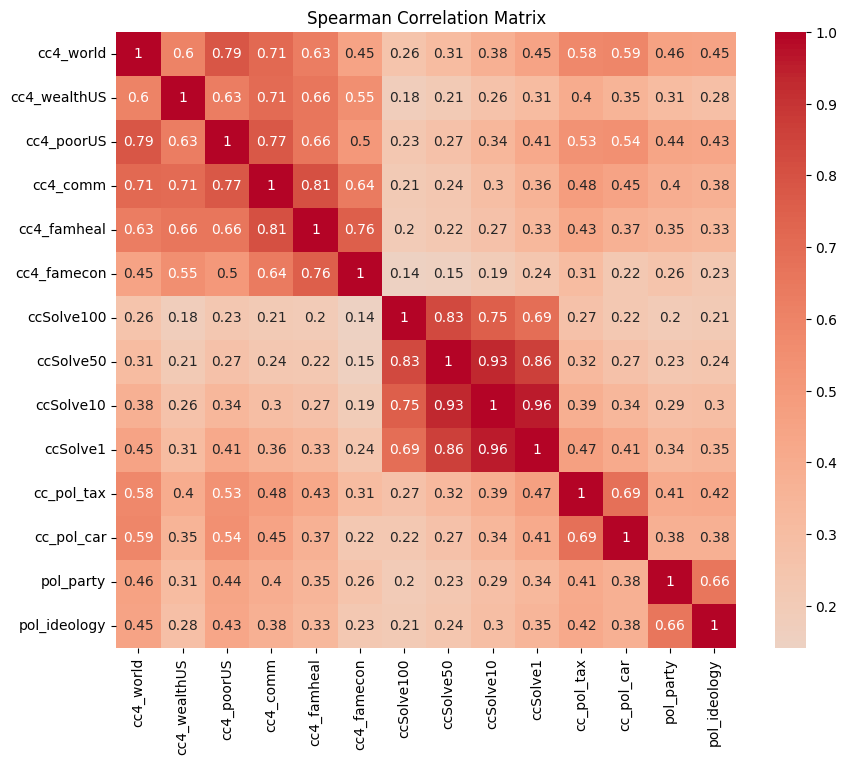

In [16]:
df_causal = df[columns_of_interest_causal]

# Compute Spearman correlation
correlation_matrix = df_causal.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title
plt.title('Spearman Correlation Matrix')
plt.show()


#### Distribution of All Variables with Density Overlay

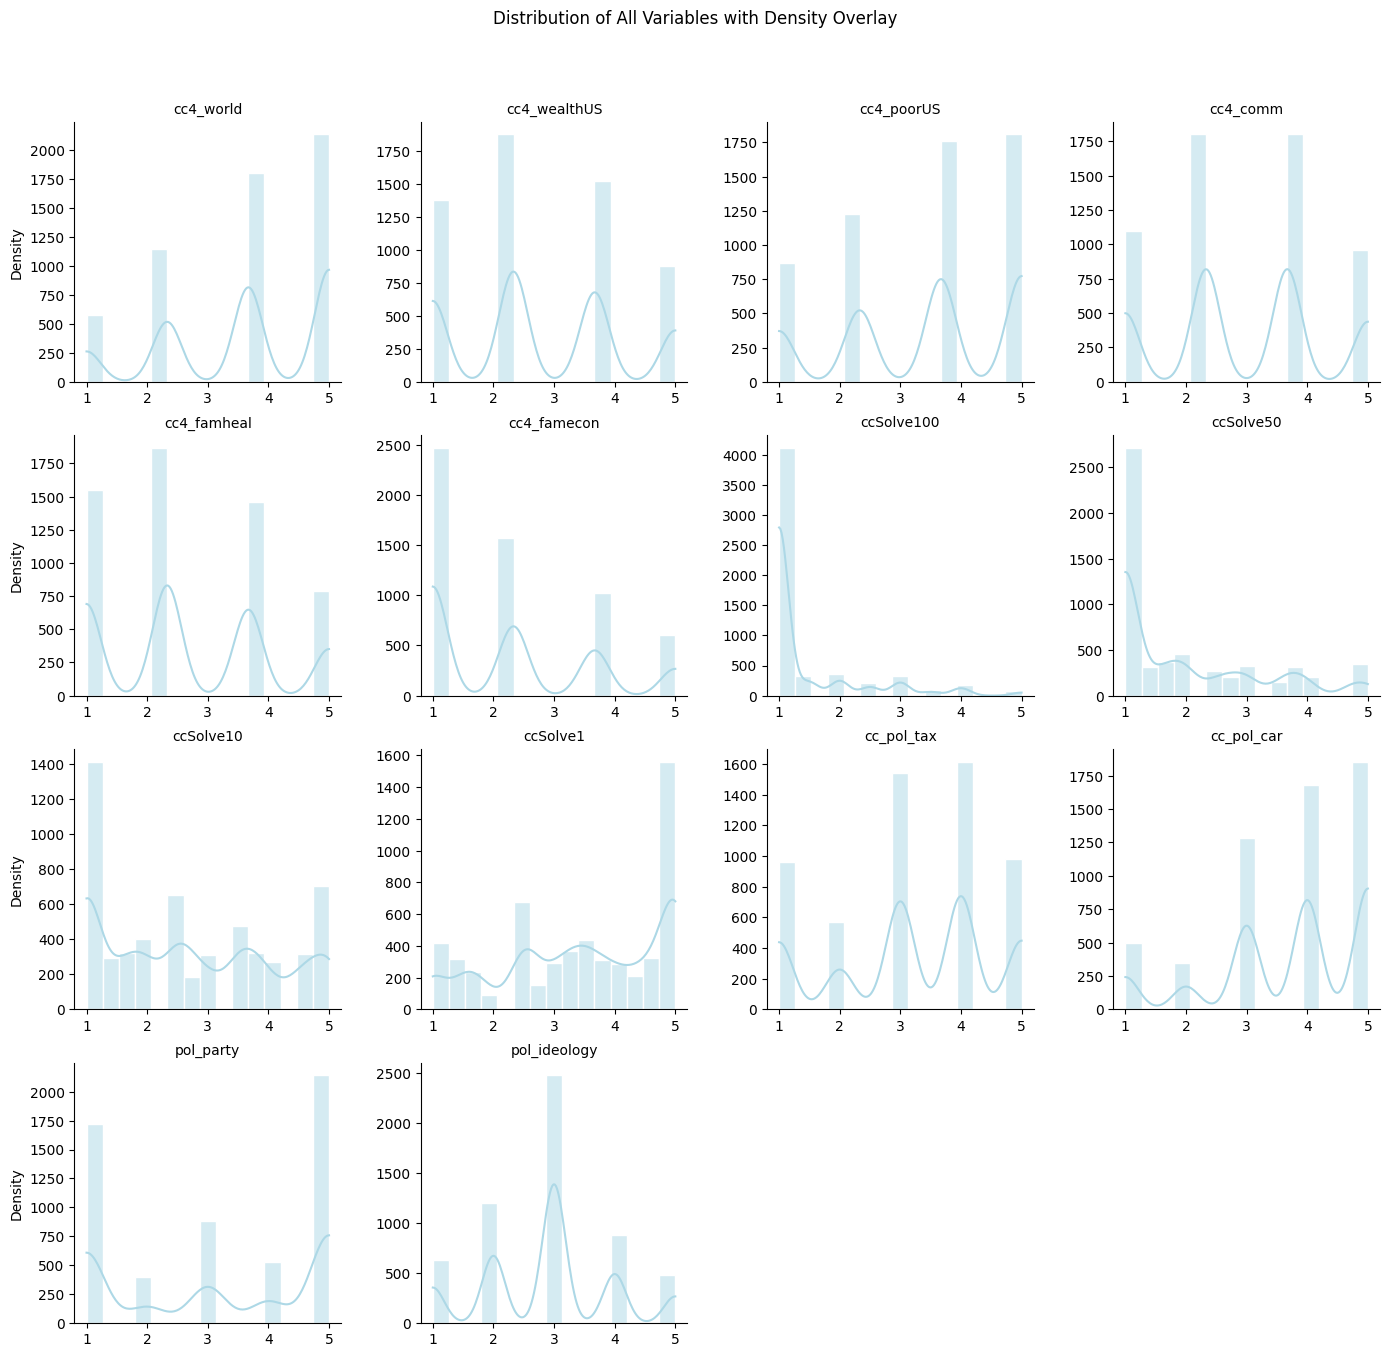

In [17]:
# Reshape data to long format for plotting
df_long = df_causal.melt(var_name="variable", value_name="value")

# Set up the FacetGrid for histogram with density overlay
g = sns.FacetGrid(df_long, col="variable", col_wrap=4, sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.histplot, x="value", bins=15, kde=True, color="lightblue", edgecolor="white")

# Adjust titles and layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Density")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of All Variables with Density Overlay")

g.set_axis_labels("", "Density")  # Remove "Value" from x-axis

# Show the plot
plt.show()


---
`cdt` relies on R packages (`pcalg`, `kpcalg`, `RCIT`) to run the PC algorithm

Since cdt internally calls R functions, we need to:
- Install R on our system (if not already installed)
- Install the required R packages (pcalg, kpcalg, RCIT)
- Ensure Python can find R (via rpy2)

##### Step 1. Install R on Your System
If you don’t have R installed, download and install it from https://cran.r-project.org/bin

##### Step 2. Open R and run the following commands
```r
install.packages("pcalg", dependencies=TRUE)
install.packages("kpcalg", dependencies=TRUE)
install.packages("RCIT", dependencies=TRUE, repos="http://R-Forge.R-project.org")
````

##### Step 3: Ensure Python Can Find R

In [18]:
import os
os.environ["R_HOME"] = "C:/Program Files/R/R-4.4.2"  # Update this with your actual R installation path
os.environ["R_USER"] = os.path.expanduser("~")

To check if R is properly linked, try running:

In [19]:
from rpy2.robjects import r
r('version')

<rpy2.robjects.vectors.ListVector object at 0x0000027B28B21F90> [19]
R classes: ('simple.list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B28B79690> [16]
R classes: ('character',)
['x86_64-w64-mingw32']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B43694A10> [16]
R classes: ('character',)
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D8F10> [16]
R classes: ('character',)
['mingw32']
  crt: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D9110> [16]
R classes: ('character',)
['ucrt']
...
  status: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D8D50> [16]
R classes: ('character',)
['87279']
  major: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D87D0> [16]
R classes: ('character',)
['R']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D8450> [16]
R classes: ('character',)
['R version 4.4.2 (2024-10-31 ucrt)']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000027B431D9D90> [16]
R classes: ('character',)
['Pile of Leaves']

### **🔹 How to Install `RCIT` and `RCoT` in R**
Since **`RCIT` and `RCoT`** are not available on **CRAN**, we need to install them directly from **GitHub** using `devtools`.

---

### **✅ Step 1: Open R and Install Required Dependencies**
Before installing `RCIT`, install its dependencies:
```r
install.packages(c("MASS", "momentchi2", "devtools"))
```

---

### **✅ Step 2: Install `RCIT` from GitHub**
Now install the `RCIT` package:
```r
library(devtools)
install_github("Diviyan-Kalainathan/RCIT")
```

This will **download and compile** the package from GitHub.

---

### **✅ Step 3: Load and Test `RCIT`**
After installation, load the package:
```r
library(RCIT)
```
Test if the functions work:
```r
RCIT(rnorm(1000), rnorm(1000), rnorm(1000))
RCoT(rnorm(1000), rnorm(1000), rnorm(1000))
```
If the installation was successful, this should **return test statistics and p-values**.

### PC

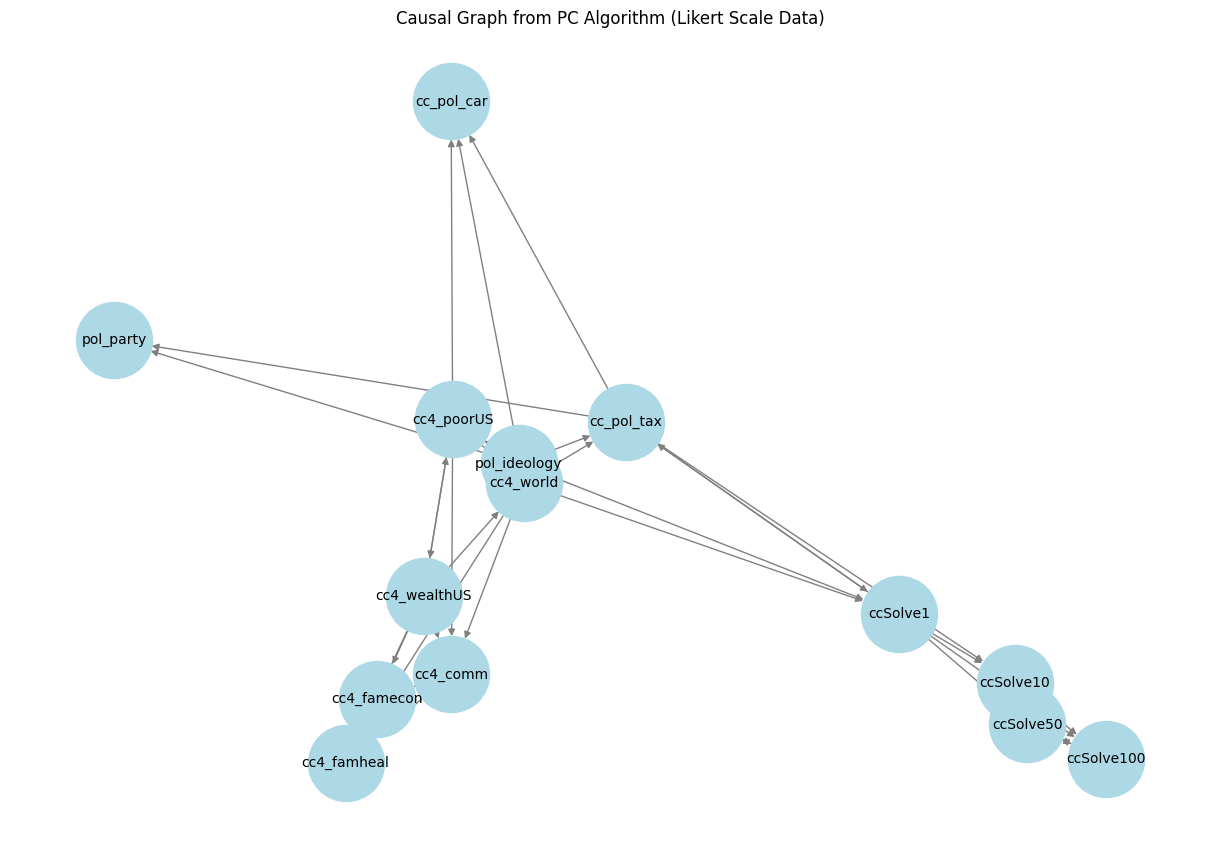

In [21]:
import networkx as nx
from cdt.causality.graph import PC
import torch

# Ensure values are numeric and between 1-5 (Likert scale)
df_causal = df_causal.apply(pd.to_numeric, errors='coerce')

# Convert to PyTorch tensor
data_tensor = torch.tensor(df_causal.values, dtype=torch.float32)

# Use PC algorithm with a conditional independence test suited for Likert-scale data
pc = PC(alpha=0.05, CItest="rcot")  # Use RCoT (Randomized Conditional Correlation Test)
graph = pc.predict(pd.DataFrame(data_tensor.numpy(), columns=df_causal.columns))

# Check if the graph has edges before plotting
if not graph.edges():
    print("No causal relationships were found!")
else:
    nx_graph = nx.DiGraph(graph.to_directed().edges())

    # Plot the causal graph using NetworkX
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(nx_graph, seed=42)  # Layout for better visualization
    nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)
    plt.title("Causal Graph from PC Algorithm (Likert Scale Data)")
    plt.show()

In [27]:
import pandas as pd

# Extract edges from the learned causal graph
edges = list(graph.edges())

# Convert to DataFrame
causal_edges_df = pd.DataFrame(edges, columns=["Cause", "Effect"])

# Display the table
from IPython.display import display
display(causal_edges_df)  # Works in Jupyter Notebook

,Cause,Effect
0,cc4_world,cc4_comm
1,cc4_world,cc4_famheal
2,cc4_world,ccSolve1
3,cc4_world,cc_pol_tax
4,cc4_world,cc_pol_car
5,cc4_wealthUS,cc4_world
6,cc4_wealthUS,cc4_poorUS
7,cc4_wealthUS,cc4_comm
8,cc4_wealthUS,cc4_famheal
9,cc4_wealthUS,cc4_famecon


This table represents the **causal relationships** detected by the **PC algorithm** between climate perception, financial policy support, and political ideology. Each row signifies a **causal direction** from a **Cause** variable to an **Effect** variable.

#### 1️⃣ Key Structural Insights
##### 🟢 Climate Perception as a Core Driver
- `cc4_world` is **highly influential**, causing:
  - `cc4_comm` (climate impact on communities)
  - `cc4_famheal` (climate impact on family health)
  - `ccSolve1` (willingness to pay a small amount)
  - `cc_pol_tax` (support for carbon tax)
  - `cc_pol_car` (support for stricter car regulations)

📌 **Interpretation:**  
👉 People's **beliefs about global climate change drive policy support**, willingness to pay, and perception of its **local and health impacts**  

##### 🔵 Interdependence Between Climate Perception Variables
- `cc4_wealthUS`, `cc4_poorUS`, and `cc4_world` **influence each other**:
  - `cc4_wealthUS` → `cc4_world`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
  - `cc4_poorUS` → `cc4_world`, `cc4_wealthUS`, `cc4_comm`, `cc_pol_car`, `pol_ideology`

📌 **Interpretation:**  
👉 **People differentiate** between climate impacts on the world, poor communities, and wealthy communities  
👉 However, **all perceptions are interconnected**, reinforcing the idea that belief in **climate change effects on specific groups influences general perceptions**

#### 2️⃣ Political Influence on Climate Policy Preferences
- **Political ideology (`pol_ideology`) directly affects**:
  - `cc4_world` (climate perception)
  - `cc4_poorUS` (perceived impact on poor communities)
  - `ccSolve1` (willingness to pay for climate policy)
  - `cc_pol_tax` (support for carbon tax)
  - `pol_party` (political party identification)

📌 **Interpretation:**  
👉 **Political ideology influences both climate perception and willingness to support financial policies**  
👉 **Partisanship (`pol_party`) is shaped by ideology**, reinforcing the role of **political polarization in climate policy debates**  

##### 🔴 The Role of Policy Preferences
- `cc_pol_tax` influences:
  - `ccSolve10`, `ccSolve1` (financial contributions)
  - `cc_pol_car` (regulatory preferences)
  - `pol_party` (political party alignment)

📌 **Interpretation:**  
👉 **Support for a carbon tax is central to both financial contributions and regulatory policy attitudes**  
👉 **Carbon tax support is also linked to political party affiliation**, confirming that economic policies **are highly politicized**

#### 3️⃣ Willingness to Pay as a Progressive Ladder
- **Financial contributions follow a hierarchical structure**:
  - `ccSolve100` ↔ `ccSolve50`
  - `ccSolve10` → `ccSolve50` → `ccSolve100`
  - `ccSolve1` → `ccSolve10`, `ccSolve50`, `ccSolve100`

📌 **Interpretation:**  
👉 People **who are willing to pay smaller amounts (`ccSolve1`, `ccSolve10`) are also more likely to accept higher costs (`ccSolve50`, `ccSolve100`)**  
👉 This suggests **a gradual increase in financial commitment**, meaning **entry-level support (small payments) is key for larger policy changes**  

#### 4️⃣ Cross-Sector Interactions
- **Health & Economic Concerns**
  - `cc4_comm` → `cc4_famheal`, `cc4_famecon`
  - `cc4_famecon` → `cc4_famheal`
  
📌 **Interpretation:**  
👉 **Economic and health concerns are closely tied** to local climate perceptions  
👉 This highlights that **people perceive climate change not just as an environmental issue, but as a direct threat to health and financial stability**

#### 5️⃣ High-Level Summary & Implications
✅ **Political ideology plays a dominant role in shaping climate perception and financial support for policies**  
✅ **Climate perceptions (global, poor, and wealthy communities) are interconnected but distinct**  
✅ **Policy preferences (carbon tax, car regulations) are highly politicized, influenced by ideology and party affiliation**  
✅ **Willingness to pay follows a stepwise structure, meaning policy acceptance increases progressively**  
✅ **Local economic and health concerns reinforce climate-related fears and influence policy opinions**  

#### 📌 Next Steps & Potential Analyses
🔹 **Check Edge Strengths** – Which relationships are strongest?  
🔹 **Compare Across Alpha Levels** – Do different statistical thresholds change results?  
🔹 **Factor Analysis** – Do **financial policy preferences and political ideology cluster separately**?  

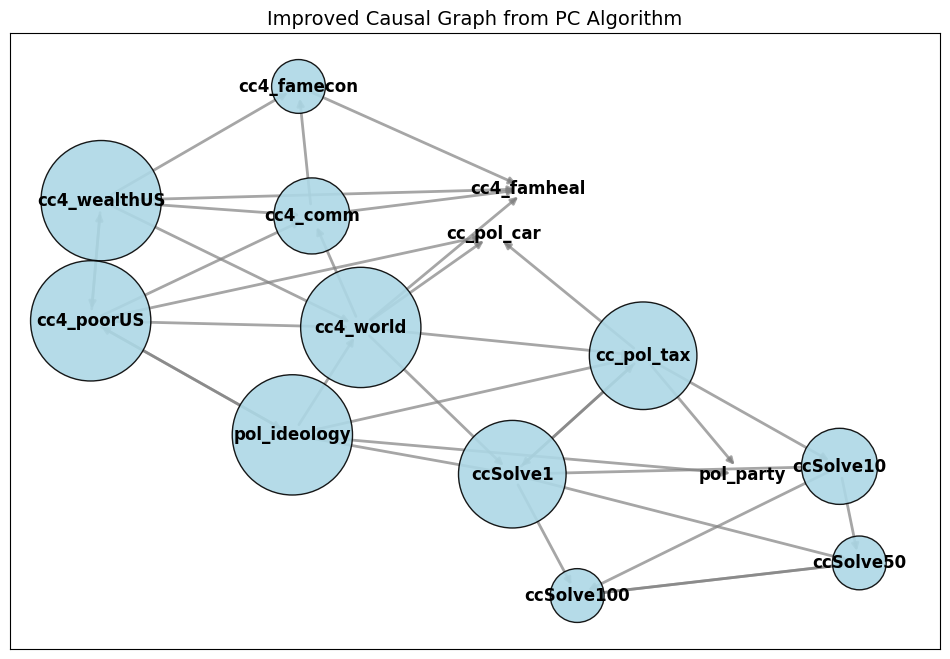

In [22]:
# Set an improved layout for better visualization
pos = nx.kamada_kawai_layout(nx_graph)  # Alternative: nx.spring_layout()

# Adjust node sizes dynamically based on degree (importance)
node_sizes = [len(list(nx_graph.neighbors(n))) * 1500 for n in nx_graph.nodes()]

# Draw nodes and edges with custom settings
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(nx_graph, pos, node_size=node_sizes, node_color="lightblue", alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(nx_graph, pos, width=2, alpha=0.7, edge_color="gray", arrows=True)

# Draw labels with better font size
nx.draw_networkx_labels(nx_graph, pos, font_size=12, font_weight="bold")

# Add a title
plt.title("Improved Causal Graph from PC Algorithm", fontsize=14)
plt.show()

This **causal graph** represents the relationships between climate change perception, financial policy support, and political ideology variables, as inferred using the **PC algorithm**

#### 1️⃣ General Structure
- The nodes represent **variables** in the dataset
- The **arrows indicate directed causal relationships** inferred by the PC algorithm
- **Larger nodes indicate more central variables**, likely having **higher degrees** (more connections)

#### 2️⃣ Key Observations
##### 🟢 Central Variables (Highly Connected)
- **`cc4_world` (Climate Change Perception - Global Impact)**
  - It is **highly central**, meaning it **strongly influences other variables**
  - Connected to **political ideology (`pol_ideology`), local community impact (`cc4_comm`), and policy preferences (`cc_pol_tax`)**
  
- **`cc4_poorUS` (Climate Change Impact on Poor Communities)**
  - Linked to **`cc4_world`** and **`pol_ideology`**, indicating that **people’s perceptions of climate impact on vulnerable groups may shape their broader climate beliefs**

- **`cc_pol_tax` (Support for Carbon Tax)**
  - Connected to **policy support (`ccSolve1`), political ideology (`pol_ideology`), and financial burden (`cc_pol_car`)**
  - Suggests that **belief in climate change influences willingness to accept economic policies**

##### 🔴 Political Variables & Their Role
- **`pol_ideology` → `cc4_world`, `cc4_poorUS`, and `cc_pol_tax`**
  - Indicates that **political ideology plays a major role in shaping climate beliefs**
  - Suggests that people’s stance on **climate issues may be influenced by their political leanings rather than direct exposure to climate effects**

- **`pol_party` → `ccSolve10`, `cc_pol_tax`**
  - Shows **a direct link between party identification and support for climate policies**
  - Political affiliation may **predict policy preferences**, particularly in financial contributions (`ccSolve*` variables)

##### 📉 Financial Policy Support Trends
- **`ccSolve100` → `ccSolve50` → `ccSolve10` → `ccSolve1`**
  - This **sequential structure** suggests that **willingness to pay follows a tiered pattern**
  - People who support **high-cost policies (`ccSolve100`) are also likely to support lower-cost policies (`ccSolve1`)**

#### 3️⃣ Insights & Interpretations
✅ **Climate perception (`cc4_world`, `cc4_poorUS`) is a key driver** of policy support, indicating that **people’s belief in climate change matters in shaping their willingness to act**  
✅ **Political ideology (`pol_ideology`, `pol_party`) is a strong upstream variable**, meaning that **political identity significantly influences climate policy support**  
✅ **Financial contributions (`ccSolve*` variables) are structured in a cascading way**, meaning that **people who support expensive climate policies also support cheaper ones**  
✅ **Economic & regulatory policy preferences (`cc_pol_tax`, `cc_pol_car`) are connected to both climate beliefs and political identity**, reinforcing the idea that **partisanship affects willingness to regulate emissions and impose taxes**  

#### 📌 Potential Next Steps
🔹 **Check Edge Strengths**: Do all causal links have strong statistical significance?  
🔹 **Compare with FCI Output**: Does the **FCI algorithm** confirm similar relationships?  
🔹 **Check Robustness**: Try using **different `alpha` thresholds** in the PC algorithm.  